# Step 1: Install dependencies:
Installs the required libraries for data handling, plotting, and (deep) reinforcement learning.


In [ ]:
!pip install yfinance pandas numpy matplotlib stable-baselines3[extra] shimmy>=2.0


# Step 2: Mount Google Drive:
Mounts Google Drive to save and load files directly from the Colab session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 3: Import libraries:
Imports necessary packages for (deep) reinforcement learning, data processing, and visualization.

In [ ]:
import gym
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from gym import spaces
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.noise import NormalActionNoise

from sklearn.model_selection import train_test_split


# Step 4: Custom train/test split:
Splits DataFrame into training and test sets based on the defined ratio.

In [ ]:
def train_test_split(df, train_ratio=0.8):
    train_size = int(len(df) * train_ratio)
    return df[:train_size].copy(), df[train_size:].copy()

# Step 5: Custom Trading Environment:
Defines the custom Gym environment that simulates stock trading with buy/sell hold actions and a realistic reward structure.

In [ ]:
class SimpleTradingEnv(gym.Env):
    def __init__(self, df, lookback=5):
        super(SimpleTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.lookback = lookback
        self.n_steps = len(self.df)
        self.current_step = self.lookback  # start after enough history for lookback window
        self.cash = 10000
        self.stock_owned = 0
        self.initial_cash = self.cash

        # Observation: 4 OHLC + 2 SMA features per day × lookback days + cash + stock_owned
        self.state_size = (4 + 2) * self.lookback + 2
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)  # action: -1 (sell all) to 1 (buy max)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.state_size,), dtype=np.float32)
        self.trade_penalty_factor = 0.01  # penalty per share traded to discourage overtrading

    def _get_obs(self):
        # Get OHLC and SMA values over lookback window
        frame = self.df.iloc[self.current_step - self.lookback:self.current_step]
        ohlc = frame[["Open", "High", "Low", "Close"]].values.flatten()
        sma5 = frame["SMA5"].values.flatten()
        sma20 = frame["SMA20"].values.flatten()
        # Combine all features into a single observation vector
        obs = np.concatenate([ohlc, sma5, sma20, [self.cash], [self.stock_owned]])
        return obs.astype(np.float32)

    def reset(self):
        # Reset environment to initial state
        self.current_step = self.lookback
        self.cash = self.initial_cash
        self.stock_owned = 0
        return self._get_obs()

    def step(self, action):
        # Get current price and portfolio value before action
        row = self.df.iloc[self.current_step]
        price = float(row["Close"])
        prev_total_asset = self.cash + self.stock_owned * price

        # Clip action to [-1, 1] and extract scala
        action = float(action[0])
        action = np.clip(action, -1, 1)

        min_trade_amount = 1
        shares_traded = 0

        # Buy logic
        if action > 0:
            max_buy = int(self.cash // price) # max shares we can afford
            shares_bought = int(action * max_buy) # fraction of max
            if shares_bought >= min_trade_amount:
                self.cash -= shares_bought * price
                self.stock_owned += shares_bought
                shares_traded = shares_bought

        # Sell logic
        elif action < 0:
            shares_sold = int(abs(action) * self.stock_owned) # fraction of owned shares
            if shares_sold >= min_trade_amount:
                self.cash += shares_sold * price
                self.stock_owned -= shares_sold
                shares_traded = shares_sold

        self.current_step += 1
        done = self.current_step >= self.n_steps - 1
        next_obs = self._get_obs()

        # Get new portfolio value after action
        next_price = float(self.df.iloc[self.current_step]["Close"]) if not done else price
        new_total_asset = self.cash + self.stock_owned * next_price

        # Reward: portfolio change minus penalty for trading too much
        reward = new_total_asset - prev_total_asset - self.trade_penalty_factor * shares_traded

        return next_obs, reward, done, {}

# Step 6: Download, preprocess, train and evaluate:
Downloads historical data for each Dow 30 stock, computes indicators, trains PPO & A2C agents, evaluates them, and compares to Buy & Hold, saves them to csv.


In [ ]:
# List of Dow Jones 30 tickers
dow30_tickers = [
    "AAPL", "AMGN", "AXP", "BA", "CAT", "CSCO", "CVX", "DIS", "DOW", "GS",
    "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KO", "MCD", "MMM", "MRK",
    "MSFT", "NKE", "PG", "CRM", "TRV", "UNH", "V", "VZ", "WBA", "WMT"
]

# Dictionary to store results per stock
results = {}

# For storing reward trajectories across all stocks
ppo_train_rewards_all = []
a2c_train_rewards_all = []
ppo_test_rewards_all = []
a2c_test_rewards_all = []


# Loop through each stock ticker
for ticker in dow30_tickers:
    print(f"\n📈 Processing: {ticker}")

    try:
        # Download historical data for the stock
        raw = yf.download(ticker, start="2018-01-01", end="2025-01-01", group_by=None)

        # Handle multi-index columns (if present)
        if isinstance(raw.columns, pd.MultiIndex):
            raw.columns = [col[1] if isinstance(col, tuple) else col for col in raw.columns]

        # Select OHLC data and clean
        df = raw[["Open", "High", "Low", "Close"]].dropna().reset_index(drop=True)
        df = df.astype(float)

        # Add technical indicators: SMA5 and SMA20
        df["SMA5"] = df["Close"].rolling(window=5).mean()
        df["SMA20"] = df["Close"].rolling(window=20).mean()
        df = df.dropna().reset_index(drop=True)  # drop initial rows without SMA

        # Split into train/test sets chronologically
        train_df, test_df = train_test_split(df, train_ratio=0.8)

        # Create training and test environments
        train_env = DummyVecEnv([lambda: SimpleTradingEnv(train_df, lookback=5)])
        test_env = SimpleTradingEnv(test_df, lookback=5)

        # Initialize PPO and A2C agents
        ppo = PPO("MlpPolicy", train_env, verbose=0)
        a2c = A2C("MlpPolicy", train_env, verbose=0)

        # Train both models
        ppo.learn(total_timesteps=50000)
        a2c.learn(total_timesteps=50000)

        # Function to collect reward sequence
        def collect_rewards(model, df):
            env = SimpleTradingEnv(df, lookback=5)
            obs = env.reset()
            rewards = []
            done = False
            while not done:
                action, _ = model.predict(obs)
                obs, reward, done, _ = env.step(action)
                rewards.append(float(reward))
            return rewards

        # Store per-timestep rewards
        ppo_train_rewards_all.append(collect_rewards(ppo, train_df))
        a2c_train_rewards_all.append(collect_rewards(a2c, train_df))
        ppo_test_rewards_all.append(collect_rewards(ppo, test_df))
        a2c_test_rewards_all.append(collect_rewards(a2c, test_df))

        # Function to evaluate an agent on the test environment
        def eval_agent(model, env):
            obs = env.reset()
            done = False
            while not done:
                action, _ = model.predict(obs)
                obs, reward, done, _ = env.step(action)
            final_price = env.df.iloc[env.current_step - 1]["Close"]
            final_value = env.cash + env.stock_owned * final_price
            return final_value


        # Evaluate both trained agents
        ppo_val = eval_agent(ppo, test_env)
        a2c_val = eval_agent(a2c, test_env)

        # Simulate Buy & Hold strategy: buy 10 shares and hold till end
        buy_hold_cash = 10000
        buy_hold_shares = 10
        start_price = test_df["Close"].iloc[0]
        end_price = test_df["Close"].iloc[-1]

        # Calculate Buy & Hold final value/Buy 10 shares if affordable
        total_cost = buy_hold_shares * start_price
        cash_left = buy_hold_cash - total_cost if buy_hold_cash >= total_cost else 0
        buy_hold_val = cash_left + buy_hold_shares * end_price

        # Calculate price change during test period
        price_change = test_df["Close"].iloc[-1] - test_df["Close"].iloc[0]

        # Store results for this ticker
        results[ticker] = {
            "PPO_Absolute": round(ppo_val, 2),
            "PPO_Profit": round(ppo_val - 10000, 2),
            "PPO_ROI": round(((ppo_val - 10000) / 10000) * 100, 2),

            "A2C_Absolute": round(a2c_val, 2),
            "A2C_Profit": round(a2c_val - 10000, 2),
            "A2C_ROI": round(((a2c_val - 10000) / 10000) * 100, 2),

            "BuyHold_Absolute": round(buy_hold_val, 2),
            "BuyHold_Profit": round(buy_hold_val - 10000, 2),
            "BuyHold_ROI": round(((buy_hold_val - 10000) / 10000) * 100, 2),

            "Price_Change": round(price_change, 2),
        }

        # Print results to console
        print(f"✅ {ticker} → PPO: {results[ticker]['PPO_Absolute']}, A2C: {results[ticker]['A2C_Absolute']}, Buy & Hold: {results[ticker]['BuyHold_Absolute']}, Price Change: {results[ticker]['Price_Change']}")
        # print(f"✅ {ticker} → PPO: {results[ticker]['PPO_Absolute']}, A2C: {results[ticker]['A2C_Absolute']}, Buy & Hold: {results[ticker]['BuyHold_Absolute']}")

    except Exception as e:
        # If anything fails for a stock, skip and log the error
        print(f"⚠️ Skipped {ticker} due to error: {e}")


# ✅ SAVE RESULTS TO CSV
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df.index.name = "Ticker"

# Save to drive folder
results_df.to_csv("/content/drive/MyDrive/trading_results.csv")
print("📄 Results saved to Google Drive → trading_results.csv")

/tmp/ipython-input-26-2704330395.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(ticker, start="2018-01-01", end="2025-01-01", group_by=None)
[*********************100%***********************]  1 of 1 completed


📈 Processing: AAPL



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ AAPL → PPO: 10911.63, A2C: 14152.78, Buy & Hold: 10718.96, Price Change: 71.9

📈 Processing: AMGN



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ AMGN → PPO: 9993.18, A2C: 9277.96, Buy & Hold: 10111.31, Price Change: 11.13

📈 Processing: AXP



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ AXP → PPO: 10949.4, A2C: 18452.32, Buy & Hold: 11322.6, Price Change: 132.26

📈 Processing: BA



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ BA → PPO: 9277.59, A2C: 7633.31, Buy & Hold: 9402.9, Price Change: -59.71

📈 Processing: CAT



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ CAT → PPO: 14202.56, A2C: 13326.85, Buy & Hold: 10834.42, Price Change: 83.44

📈 Processing: CSCO



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ CSCO → PPO: 9980.45, A2C: 11101.96, Buy & Hold: 10072.5, Price Change: 7.25

📈 Processing: CVX



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ CVX → PPO: 8962.23, A2C: 9406.08, Buy & Hold: 9909.1, Price Change: -9.09

📈 Processing: DIS



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ DIS → PPO: 14381.0, A2C: 13013.01, Buy & Hold: 10235.23, Price Change: 23.52

📈 Processing: DOW



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ DOW → PPO: 9241.28, A2C: 8192.53, Buy & Hold: 9951.86, Price Change: -4.81

📈 Processing: GS



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ GS → PPO: 13347.64, A2C: 18435.32, Buy & Hold: 12458.08, Price Change: 245.81

📈 Processing: HD



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ HD → PPO: 11000.75, A2C: 12440.33, Buy & Hold: 10702.22, Price Change: 70.22

📈 Processing: HON



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ HON → PPO: 11322.11, A2C: 12429.15, Buy & Hold: 10409.98, Price Change: 41.0

📈 Processing: IBM



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ IBM → PPO: 13342.76, A2C: 16168.64, Buy & Hold: 10832.94, Price Change: 83.29

📈 Processing: INTC



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ INTC → PPO: 6997.12, A2C: 6089.37, Buy & Hold: 9849.57, Price Change: -15.04

📈 Processing: JNJ



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ JNJ → PPO: 9576.05, A2C: 8982.12, Buy & Hold: 9793.83, Price Change: -20.62

📈 Processing: JPM



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ JPM → PPO: 12573.21, A2C: 16502.17, Buy & Hold: 10882.25, Price Change: 88.23

📈 Processing: KO



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ KO → PPO: 11040.39, A2C: 10676.36, Buy & Hold: 10040.53, Price Change: 4.05

📈 Processing: MCD



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ MCD → PPO: 10953.87, A2C: 10723.72, Buy & Hold: 10109.66, Price Change: 10.97

📈 Processing: MMM



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ MMM → PPO: 12392.31, A2C: 11538.81, Buy & Hold: 10475.54, Price Change: 47.55

📈 Processing: MRK



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ MRK → PPO: 9736.47, A2C: 9352.4, Buy & Hold: 9950.32, Price Change: -4.97

📈 Processing: MSFT



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ MSFT → PPO: 10003.3, A2C: 13272.99, Buy & Hold: 11008.07, Price Change: 100.81

📈 Processing: NKE



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ NKE → PPO: 9953.08, A2C: 7452.3, Buy & Hold: 9708.95, Price Change: -29.11

📈 Processing: PG



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ PG → PPO: 9781.65, A2C: 11337.84, Buy & Hold: 10163.95, Price Change: 16.39

📈 Processing: CRM



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ CRM → PPO: 16998.69, A2C: 16124.47, Buy & Hold: 11230.59, Price Change: 123.06

📈 Processing: TRV



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ TRV → PPO: 14931.66, A2C: 13568.39, Buy & Hold: 10788.44, Price Change: 78.84

📈 Processing: UNH



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ UNH → PPO: 8135.32, A2C: 10422.22, Buy & Hold: 10063.88, Price Change: 6.39

📈 Processing: V



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ V → PPO: 13260.19, A2C: 11002.23, Buy & Hold: 10752.43, Price Change: 75.24

📈 Processing: VZ



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ VZ → PPO: 10111.36, A2C: 13134.66, Buy & Hold: 10088.82, Price Change: 8.88

📈 Processing: WBA



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ WBA → PPO: 5575.62, A2C: 3880.01, Buy & Hold: 9835.43, Price Change: -16.46

📈 Processing: WMT



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_alg

✅ WMT → PPO: 11736.47, A2C: 17504.02, Buy & Hold: 10376.49, Price Change: 37.65
📄 Results saved to Google Drive → trading_results.csv


# Optional: Inspect policy decisions
Tests how each trained model responds to selected input states to verify policy behavior

In [ ]:
# # Policy Response Inspection Block

# def test_policy_response(model, model_name, sample_states):
#     print(f"\n🔍 Policy inspection for {model_name}:")
#     for i, state in enumerate(sample_states):
#         action, _ = model.predict(np.array(state).reshape(1, -1))
#         print(f"Input {i+1}: {state} → Action: {action[0]}")


# sample_states = [
#     [0] * ((4+2)*5 + 2),                                # all zeros, adjusted for new state size
#     [100] * ((4)*5) + [10000]*5 + [100]*5 + [10000, 100],  # just example big values with indicators and holdings (adjust if needed)
#     [1] * ((4)*5) + [1]*5 + [1]*5 + [10000, 100],           # flat prices + SMA + holdings
#     test_env.reset(),                                      # real current market state
# ]

# test_policy_response(ppo, "PPO", sample_states)
# test_policy_response(a2c, "A2C", sample_states)
# # test_policy_response(ddpg, "DDPG", sample_states)


# Visual: Plot ROI comparison:
Plots bar chart comparing ROI across all strategies per stock.

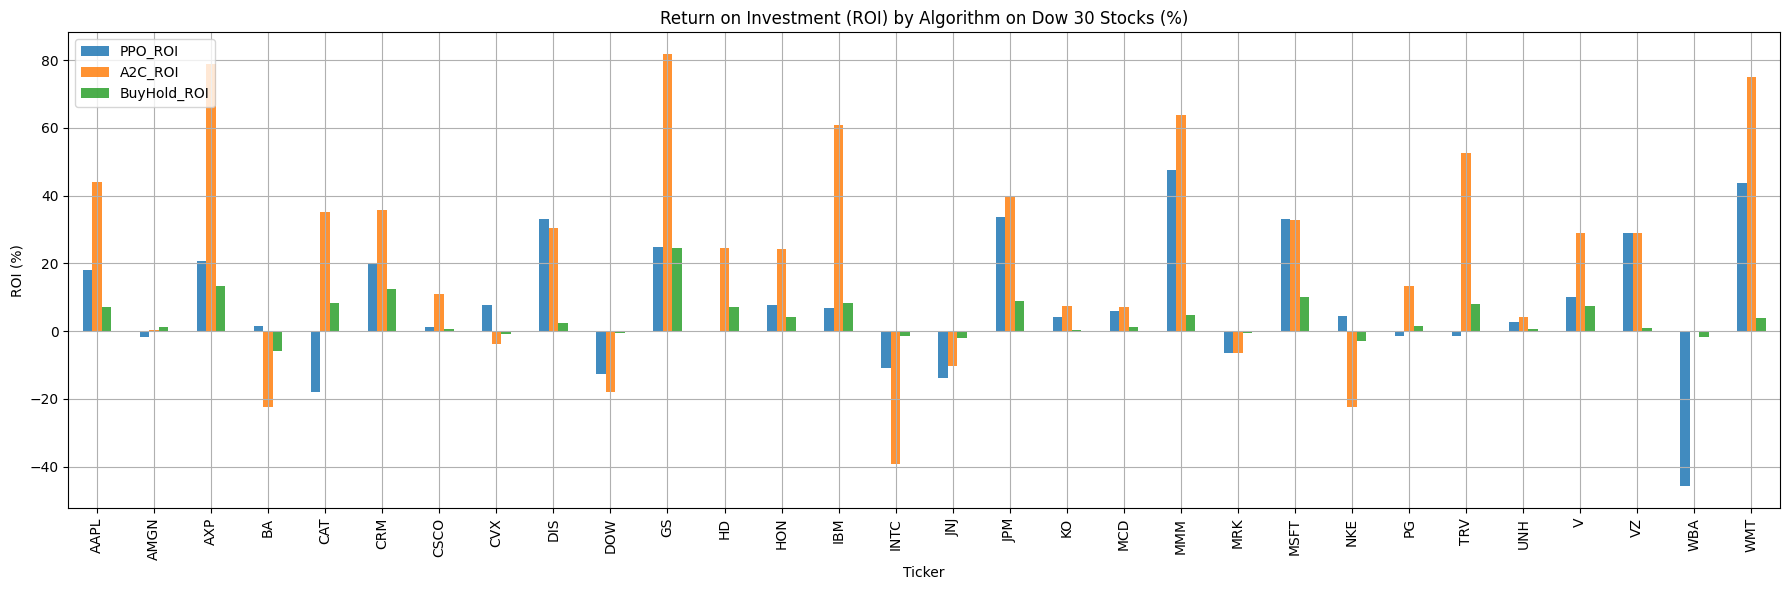

In [ ]:
# Transpose and sort results DataFrame by ticker
results_df = pd.DataFrame(results).T.sort_index()

# Plot ROI comparison for PPO, A2C, and Buy & Hold
results_df[["PPO_ROI", "A2C_ROI", "BuyHold_ROI"]].plot(kind="bar", figsize=(18,6), alpha=0.85)

# Add plot title and labels
plt.title("Return on Investment (ROI) by Algorithm on Dow 30 Stocks (%)")
plt.ylabel("ROI (%)")
plt.xlabel("Ticker")
plt.xticks(rotation=90) # rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()


# Visual: Plot portfolio value comparison:
Plots the final portfolio values per strategy for each stock.

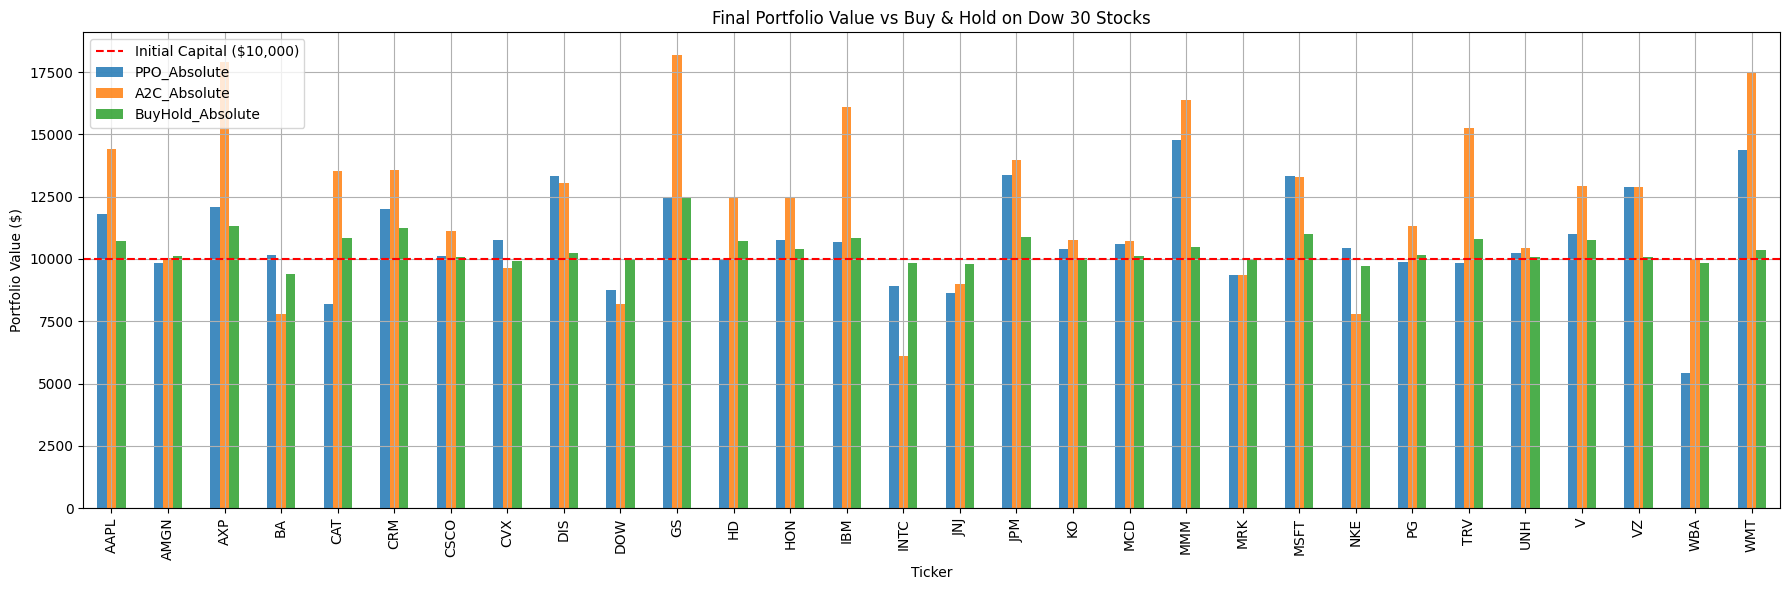

In [ ]:
# Plot final portfolio values for PPO, A2C, and Buy & Hold
results_df[["PPO_Absolute", "A2C_Absolute", "BuyHold_Absolute"]].plot(kind="bar", figsize=(18,6), alpha=0.85)

# Add plot title and axis labels
plt.title("Final Portfolio Value vs Buy & Hold on Dow 30 Stocks")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Ticker")
plt.xticks(rotation=90) # Rotate ticker labels for better readability

# Show grid for visual clarity
plt.grid(True)

# Draw a red dashed line at the initial capital of $10,000
plt.axhline(10000, color='red', linestyle='--', linewidth=1.5, label='Initial Capital ($10,000)')
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()


# Visual: Cumulative reward curves
Plots cumulative reward during training and testing to visualize how the agent’s portfolio grows over time.


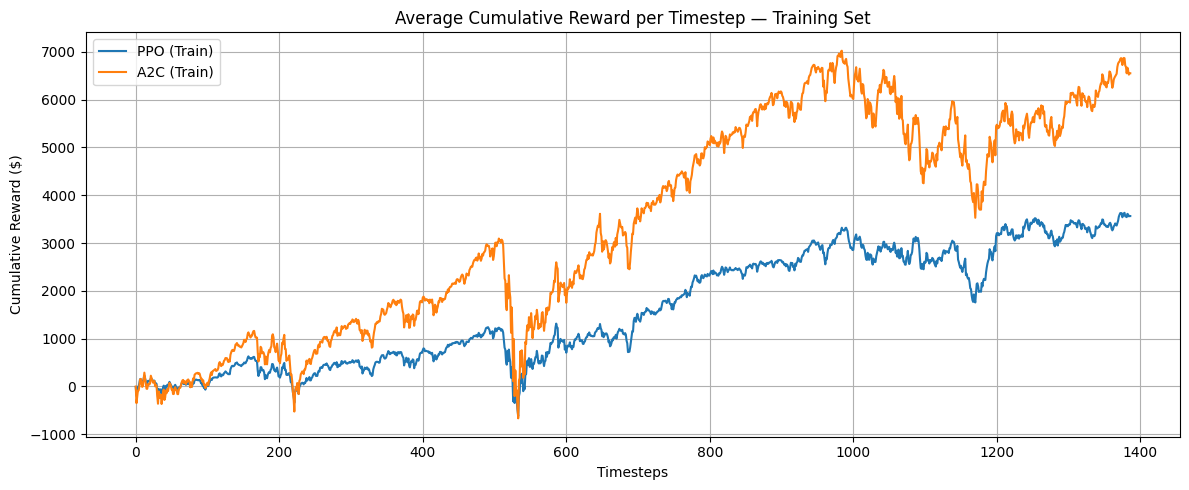

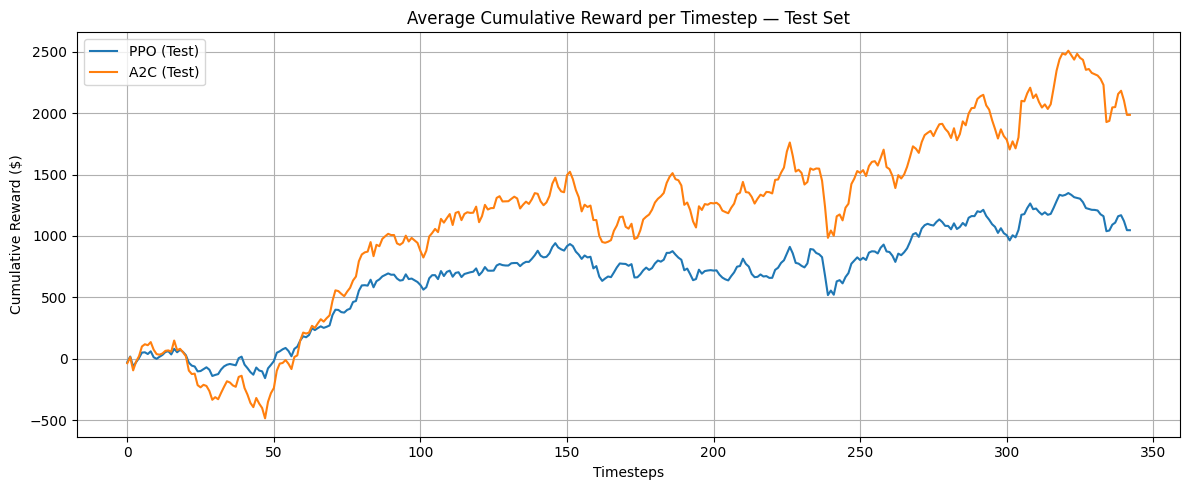

In [ ]:
# Utility to pad shorter sequences with NaNs
def pad_sequences(seq_list):
    max_len = max(len(s) for s in seq_list)
    return np.array([np.pad(s, (0, max_len - len(s)), constant_values=np.nan) for s in seq_list])

# Pad and compute average reward per timestep
ppo_train_mean = np.nanmean(pad_sequences(ppo_train_rewards_all), axis=0)
a2c_train_mean = np.nanmean(pad_sequences(a2c_train_rewards_all), axis=0)
ppo_test_mean = np.nanmean(pad_sequences(ppo_test_rewards_all), axis=0)
a2c_test_mean = np.nanmean(pad_sequences(a2c_test_rewards_all), axis=0)

# Plot average cumulative reward (Training)
plt.figure(figsize=(12,5))
plt.plot(np.cumsum(ppo_train_mean), label="PPO (Train)")
plt.plot(np.cumsum(a2c_train_mean), label="A2C (Train)")
plt.title("Average Cumulative Reward per Timestep — Training Set")
plt.xlabel("Timesteps")
plt.ylabel("Cumulative Reward ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot average cumulative reward (Test)
plt.figure(figsize=(12,5))
plt.plot(np.cumsum(ppo_test_mean), label="PPO (Test)")
plt.plot(np.cumsum(a2c_test_mean), label="A2C (Test)")
plt.title("Average Cumulative Reward per Timestep — Test Set")
plt.xlabel("Timesteps")
plt.ylabel("Cumulative Reward ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
